# Multisession registration with CaImAn

This notebook will help to demonstrate how to use CaImAn on movies recorded in multiple sessions. CaImAn has in-built functions that align movies from two or more sessions and try to recognize components that are imaged in some or all of these recordings.

The basic function for this is `caiman.base.rois.register_ROIs()`. It takes two sets of spatial components and finds components present in both using an intersection over union metric and the Hungarian algorithm for optimal matching.
`caiman.base.rois.register_multisession()` takes a list of spatial components, aligns sessions 1 and 2, keeps the union of the matched and unmatched components to register it with session 3 and so on.

In [1]:
from IPython import get_ipython
from matplotlib import pyplot as plt
import numpy as np
import pickle
import h5py
import glob
import pims_nd2
import pandas as pd
from collections import OrderedDict
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from itertools import combinations
import scipy.stats as stats
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import tifffile as tf
import os as os

from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.utils.utils import download_demo
import tifffile as tiff

import sys
sys.path.append('..')
from placecode.spatial_coding_functions import cell_morphology
from placecode.cross_registration_functions import CellTrackingMultipleAnimals as celltrack


try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

loading the files and trying to make everything automatic
running multiple conditions per multiple animals

In [17]:
animals=['OPI2356']
conditions=['bl_d1','bl_d2','24h_post','novel_belt_d1','novel_belt_d2','novel_belt_d3']
conditions=['bl_d1','bl_d2','24h_post']#,'novel_belt_d1','novel_belt_d2','novel_belt_d3']
conditions=['novel_belt_d1','novel_belt_d2','novel_belt_d3']

Initializing the necessary files for cross registration

In [35]:
files_list=OrderedDict()
templates_list=OrderedDict()
templates_list_mc=OrderedDict()
cnmf_list=OrderedDict()
spatials=OrderedDict()
dims=OrderedDict()
assignments=OrderedDict()
cr_reg_cells=OrderedDict()
cr_reg_cells_df=OrderedDict()

for animal in animals:      

    # Load multisession data (spatial components and mean intensity templates) (should be replaced by actual data)
    home_folder=f'D:/sd_project_pbox/exported_data/{animal}/'
    raw_data_folder=f'D:/sd_project_pbox/raw_data/{animal}'
    output_folder=f'D:/sd_project_pbox/results/{animal}/'

    files_list[animal]=[]
    templates_list[animal]=[]
    templates_list_mc[animal]=[]
    cnmf_list[animal]=[]
    spatials[animal]=[]
    dims[animal]=[]
    assignments[animal]=[]
    cr_reg_cells[animal]=[]
    cr_reg_cells_df[animal]=[]
# spatials=[cnmf_1.estimates.A,cnmf_2.estimates.A,cnmf_3.estimates.A]
# dims=cnmf_1.dims

    for condition in conditions:

        #finding file paths
        fpath= glob.glob(f"{home_folder}/{animal}_{condition}/*.hdf5")[0]
        files_list[animal].append(fpath)

        #sstoring cnfs
        cnmf_ind=cnmf.load_CNMF(fpath,'r')
        cnmf_list[animal].append(cnmf_ind)
        #sotring spatial components
        spatial=cnmf_ind.estimates.A
        spatials[animal].append(spatial)
        #storing dims
        dim=cnmf_ind.dims
        dims[animal].append(dim)

        #template paths
        template_path=glob.glob(f"{raw_data_folder}/*{condition}/*.nd2")[0]
        nikon_movie=pims_nd2.ND2_Reader(template_path)
        template=np.mean(nikon_movie[:600],axis=0)
        templates_list[animal].append(template)

        #template paths motion correction
        template_path_mc=glob.glob(f"{home_folder}/*{condition}/*.h5")[0]
        templates_list_mc[animal].append(template)

c:\Users\ttami\anaconda3\envs\caiman\lib\site-packages\pims\base_frames.py:478: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


In [31]:
test=h5py.File(template_path_mc)['template']

<Axes: >

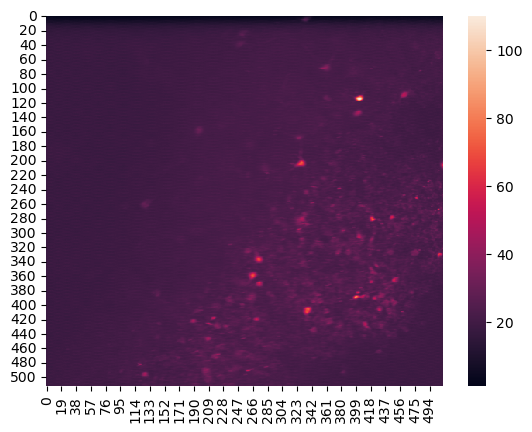

In [45]:
sns.heatmap(templates_list_mc[animal][0])

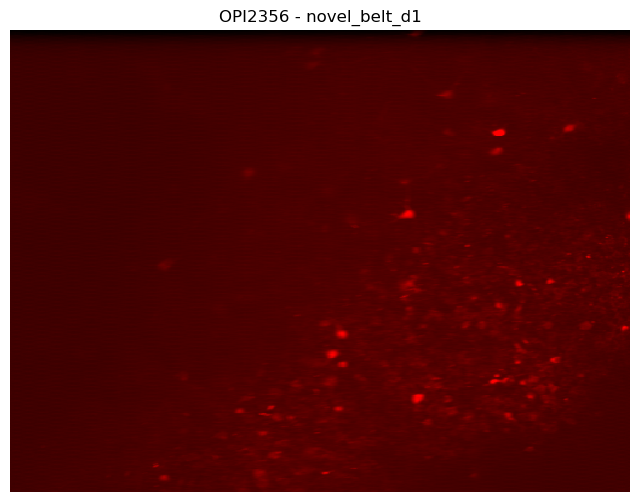

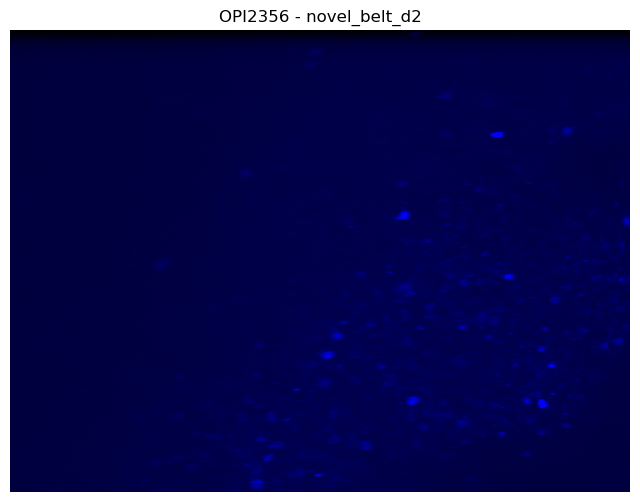

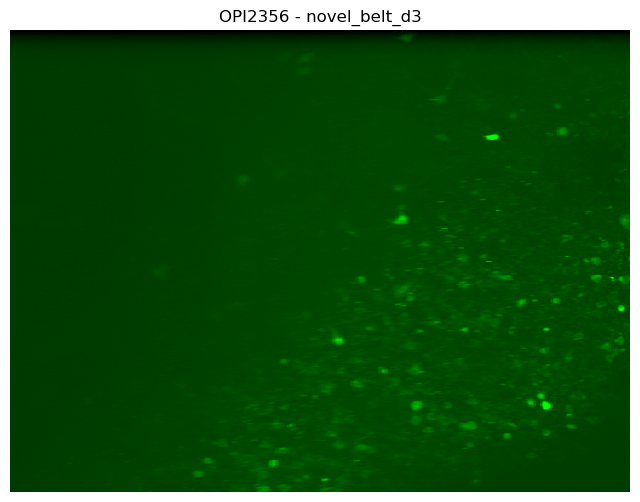

In [58]:
#plotting tiff of the template things after bences code
colors = ['#FFCCCC', '#ADD8E6', '#90EE90'] # Light Red, Light Blue, Light Green
colors=['#FF0000','#0000FF','#00FF00']  #red, blue,green

for animal in animals:
    for i,condition in enumerate(conditions):
        dataset=templates_list_mc[animal][i]
        cmap = LinearSegmentedColormap.from_list("colors", ["#000000", colors[i]])
        plt.figure(figsize=(8, 6))
        sns.heatmap(dataset, cmap=cmap,cbar=False,vmax=70)
        plt.title(f'{animal} - {condition}')
        plt.axis('off')
        tiff_filename = f'{output_folder}/{animal}_{condition}_template.tiff'
        plt.savefig(tiff_filename, format='tiff', dpi=300, bbox_inches='tight', pad_inches=0)
        plt.show()

In [34]:
templates_list_mc

OrderedDict([('OPI2356', [])])

In [52]:
#plotting and storing multilayer tiffs from nd2 files


colors=['#FF0000','#0000FF','#00FF00'] #corresponding to red,blue and green
colors = ['#FFCCCC', '#ADD8E6', '#00FF00'] # Light Red, Light Blue, Green
colors = ['#FFCCCC', '#ADD8E6', '#90EE90'] # Light Red, Light Blue, Light Green

for animal in animals:
    for i,condition in enumerate(conditions):
        cmap = LinearSegmentedColormap.from_list("colors", ["#000000", colors[i]])
        image=templates_list[animal][i]
        plt.figure(figsize=(8, 6))
        sns.heatmap(image, cmap=cmap,vmax=40,cbar=False)
        plt.title(f'{animal} - {condition}')
        plt.ioff()



# Create a multi-layer TIFF file
for animal in animals:
    output_folder=f'D:/sd_project_pbox/results/{animal}'
    with tiff.TiffWriter(f'{output_folder}/{animal}_conditions_overlay_new.tiff') as tif:
        for i, condition in enumerate(conditions):
            cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#000000", colors[i]])
            image = templates_list[animal][i]
            
            # Plot heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(image, cmap=cmap, vmax=40, cbar=False)
            plt.title(f'{animal} - {condition}')
            plt.axis('off')  # Turn off axis for cleaner image
            
            # Convert plot to image array
            plt.tight_layout()  # Ensure plots are not cropped
            plt.savefig('temp.png')  # Save temporary image
            plt.close()  # Close plot
            
            # Read image from file and write to TIFF
            image_data = plt.imread('temp.png')
            tif.save(image_data)# compress=6)  # Save image to TIFF with compression level 6
            
            plt.clf()  # Clear plot for next iteration

    print("Multi-layer TIFF file saved successfully.")



C:\Users\ttami\AppData\Local\Temp\ipykernel_12608\2513050360.py:37: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(image_data)# compress=6)  # Save image to TIFF with compression level 6
C:\Users\ttami\AppData\Local\Temp\ipykernel_12608\2513050360.py:37: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(image_data)# compress=6)  # Save image to TIFF with compression level 6
C:\Users\ttami\AppData\Local\Temp\ipykernel_12608\2513050360.py:37: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(image_data)# compress=6)  # Save image to TIFF with compression level 6


Multi-layer TIFF file saved successfully.


C:\Users\ttami\AppData\Local\Temp\ipykernel_12608\2513050360.py:37: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(image_data)# compress=6)  # Save image to TIFF with compression level 6
C:\Users\ttami\AppData\Local\Temp\ipykernel_12608\2513050360.py:37: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(image_data)# compress=6)  # Save image to TIFF with compression level 6


Multi-layer TIFF file saved successfully.


C:\Users\ttami\AppData\Local\Temp\ipykernel_12608\2513050360.py:37: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(image_data)# compress=6)  # Save image to TIFF with compression level 6


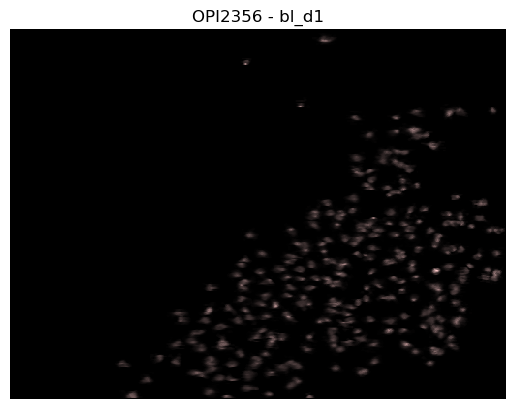

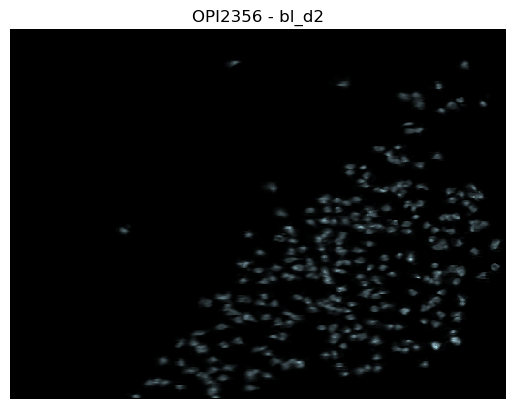

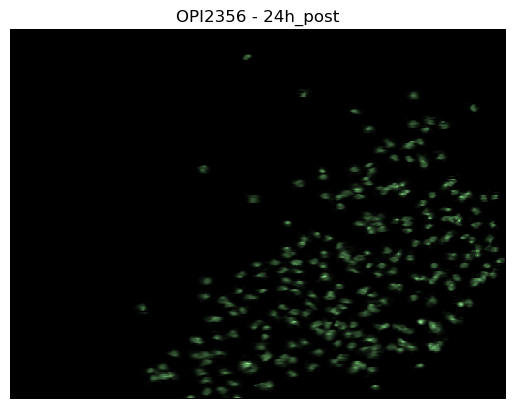

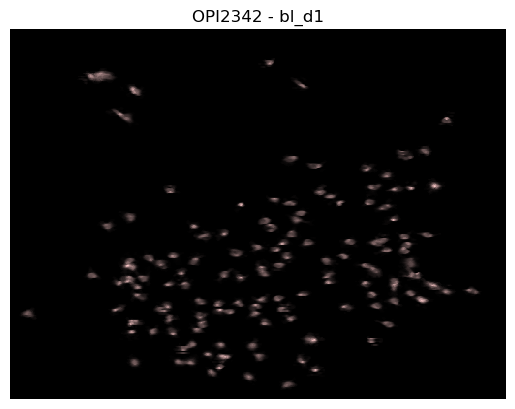

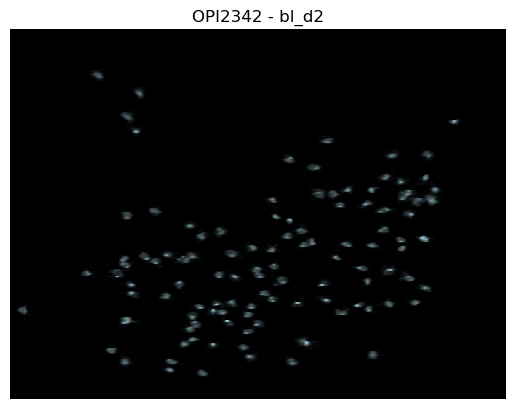

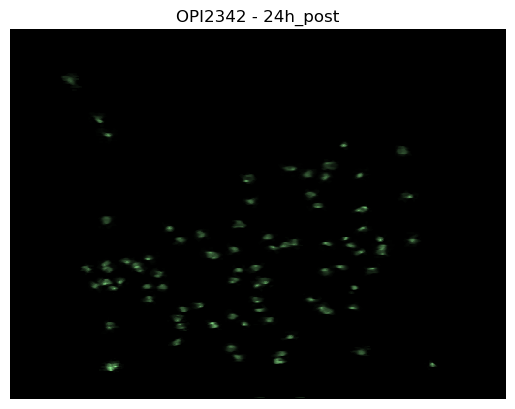

In [16]:
#plotting files post movement correction

spatials_to_plot=OrderedDict()
colors = ['#FFCCCC', '#ADD8E6', '#90EE90']

for animal in animals:
    output_folder=f'D:/sd_project_pbox/results/{animal}'
    for i,condition in enumerate(conditions):
        #opening the file
        file=files_list[animal][i] 
        #isolating spatials
        spatial=cell_morphology(file) 
        # #make everything appear in 2D
        spatial = np.transpose(spatial, axes=[2, 1,0])  # move neuron index to end
        spatial=np.sum(spatial,axis=0) #collapsinf the 3d array into 2d array so that have all of the cel
        cmap = LinearSegmentedColormap.from_list("colors", ["#000000", colors[i]])
        sns.heatmap(spatial,cbar=False,cmap=cmap)
        #plt.imshow(spatial)
        plt.axis('off')
        plt.title(f'{animal} - {condition}')

        tiff_filename = f'{output_folder}/{animal}_{condition}.tiff'
        plt.savefig(tiff_filename, format='tiff', dpi=300, bbox_inches='tight', pad_inches=0)
        
        plt.show()
        



## Use `register_multisession()`

The function `register_multisession()` requires 3 arguments:
- `A`: A list of ndarrays or scipy.sparse.csc matrices with (# pixels X # component ROIs) for each session
- `dims`: Dimensions of the FOV, needed to restore spatial components to a 2D image
- `templates`: List of ndarray matrices of size `dims`, template image of each session

In [103]:
for animal in animals:
    spatial_union, assignments_per_animal, matchings = register_multisession(A=spatials[animal], dims=dims[animal][0])
    assignments[animal]=assignments_per_animal


c:\Users\ttami\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


FInd the rows where there are no NaN values. Meaning find cells that are cross registered across all conditions

In [104]:
# Find the rows where there are no NaN values
#meaning where are the cells in all of the days

for animal in animals:    
    cr_reg_cells[animal] = assignments[animal][~np.isnan(assignments[animal]).any(axis=1)].astype(int)
    cr_reg_cells_df[animal]=pd.DataFrame(data=cr_reg_cells[animal],columns=conditions)

In [106]:
spatials_to_plot=OrderedDict()

for animal in animals:
    for i,condition in enumerate(conditions):
        #opening the file
        file=files_list[animal][i] 
        #isolating spatials
        all_cells=cell_morphology(file) 
        #isolating the spatial coordinates only of the crss registered cells
        cross_reg_spatial=all_cells[:,:,cr_reg_cells_df[animal].iloc[:,i].values]
        spatial=cross_reg_spatial
        #make everything appear in 2D
        spatial = np.transpose(spatial, axes=[2, 1,0])  # move neuron index to end
        spatial=np.sum(spatial,axis=0) #collapsinf the 3d array into 2d array so that have all of the cel
        #make all the values above 0 to 1 so that I can have whole cells in the plotting
        spatial[spatial>0]=1
        spatials_to_plot[f'{animal}_{condition}']=spatial

        



In [ ]:
colors_list=['blue','red','green']

for animal in animals:
    plt.figure(figsize=(10, 10))
    output_folder=f'D:/sd_project_pbox/results/{animal}'

    for i, condition in enumerate(conditions):
        cell_color=colors_list[i]
        spatial=spatials_to_plot[f'{animal}_{condition}']
        cmap = mcolors.ListedColormap([(0,0,0,0), cell_color])
        bounds = [0, 1, 2]  # Define the boundaries for the colormap
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

        # Display the array with the defined colormap
        plt.imshow(spatial, cmap=cmap, norm=norm)
        # Save the figure as a TIFF file
    plt.title(f'{animal}\n{conditions}\nOverlay')
    plt.axis('off')  # Hide axis
    plt.savefig(f'{output_folder}/{animal}_conditions_overlay.tiff', format='tiff', dpi=300)
    
    # Save the figure as a PNG file
    plt.savefig(f'{output_folder}/{animal}_conditions_overlay.png', format='png', dpi=300)

    plt.show()

In [115]:
for animal in animals:
    output_folder=f'D:/sd_project_pbox/results/{animal}'
    layers = []
    
    for i, condition in enumerate(conditions):
        cell_color = colors_list[i]
        spatial = spatials_to_plot[f'{animal}_{condition}']
        
        # Create an RGBA image where zero values are transparent and one values are opaque
        rgba_image = np.zeros((spatial.shape[0], spatial.shape[1], 4), dtype=np.uint8)
        rgba_image[spatial == 1] = mcolors.to_rgba(cell_color)  # Alpha defaults to 1 (fully opaque) for non-zero values
        
        # Append the RGBA image to the layers list
        layers.append(rgba_image)

    # Save layers as a multi-layered TIFF file
    tf.imwrite(os.path.join(output_folder, f'{animal}_conditions_overlay_layers.tif'), layers, photometric='rgb')

    print(f'Saved {animal}_conditions_overlay_layers.tif')

Saved OPI2356_conditions_overlay_layers.tif
Saved WEZ8917_conditions_overlay_layers.tif
Saved OPI2342_conditions_overlay_layers.tif


In [ ]:
all_cells=cell_morphology(test)
cross_reg_spatial=all_cells[:,:,cr_reg_cells_df['OPI2356'].iloc[:,0].values]

In [ ]:
spatial=cross_reg_spatial
spatial = np.transpose(spatial, axes=[2, 1,0])  # move neuron index to end
spatial=np.sum(spatial,axis=0) #collapsinf the 3d array into 2d array so that have all of the cells in one matrix